# Create report at extent-level (tile, basin, etc)
#### performs masking LC to create mask applied before for zonal stats of AGB

In [1]:
try:
    import geopandas as gpd
    !pip install -U plotnine
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
    
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer
import contextily as ctx

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *

from plotnine import *
print("Importing packages complete.")
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Importing packages complete.


# Get the dictionary created from the building of the extent-level stack
extent_stack.ipynb

In [12]:
BASIN_COG_DICT = {
    'landcover_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_7060157640_cog.tif',
 'biomass_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog.tif',
 'standage_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/standage_7060157640_cog.tif',
 'extent_gdf_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/extent_7060157640_lev06.gpkg',
 'tcc2020_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tcc2020_7060157640_cog.tif',
 'tccslope_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccslope_7060157640_cog.tif',
 'tccpvalue_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/tccpvalue_7060157640_cog.tif'
}

In [ ]:
# Calc extent area
extent_id = BASIN_COG_DICT['extent_gdf_fn'].split('_')[-2]

# Get extent gdf
EXTENT_gdf = gpd.read_file(BASIN_COG_DICT['extent_gdf_fn'])

basin_area_ha = EXTENT_gdf.area.to_list()[0] / 1e4
print(f'Area (ha.) of extent id {extent_id}:\t\t{round(basin_area_ha,2)')

#### Replace the tile or basin ID in the current dict with any already run

In [20]:
if False:
    TILE_NUM_LIST = [2139, 3358, 3204, 3203, 2832, 3265, 2485]
    TILE_NUM = TILE_NUM_LIST[0]

    HYBAS_ID = 7060157640

    FOCAL_EXTENT_ID = HYBAS_ID #TILE_NUM

    for key, value in BASIN_COG_DICT.items():
        BASIN_COG_DICT[key] = value.replace(value.split('_')[-2], str(FOCAL_EXTENT_ID))
        #print(value.split('_')[-2])
    BASIN_COG_DICT

#### Plot clip extent within boreal 
This will fail if the TILE_NUM specified is NOT in the data frame

In [21]:
os.path.basename(BASIN_COG_DICT['extent_gdf_fn'])

'extent_7060157640_lev06.gpkg'

Extent ID: 7060157640
Plot...
Plot...


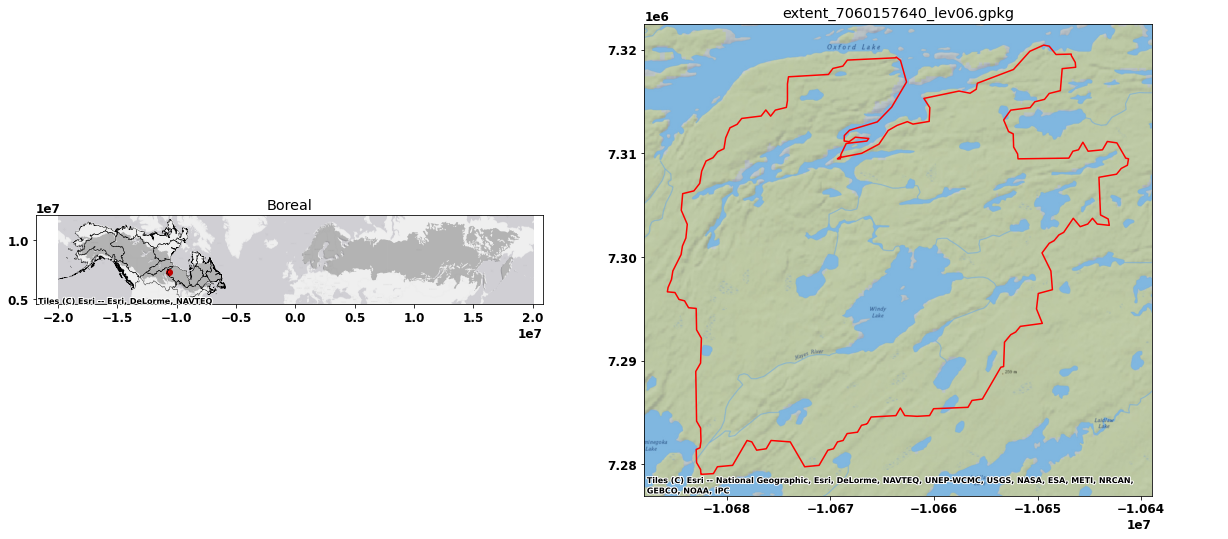

In [30]:
SHOW_FULL_EXTENT = False

print(f'Extent ID: {extent_id}')

print('Plot...')
f, (ax1, ax2) = plt.subplots(figsize=(20, 25), ncols=2, nrows=1)
ax1.set_title(f"Boreal")
ax2.set_title(os.path.basename(BASIN_COG_DICT['extent_gdf_fn']))

xmin, xmax, ymin, ymax = [-180, 180, 40, 80]

# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Get the basins
hybas_border = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev03_vc1.gpkg', bbox=(xmin, ymin, xmax, ymax))
hybas_border[hybas_border.intersects(SUB_DOMAIN_selection_geometry)].to_crs(3857).boundary.plot(linewidth=0.25, color='black', ax=ax1)

EXTENT_gdf.to_crs(3857).boundary.plot(color='red', linewidth=1, ax=ax1)
    
print('Plot...')
EXTENT_gdf.centroid.to_crs(3857).plot(color='red', ax=ax1)
EXTENT_gdf.to_crs(3857).boundary.plot(color='red', ax=ax2)
boreal_gdf.cx[xmin:xmax, ymin:ymax].to_crs(3857).plot(alpha=0.25, color='black', marker = '---', ax=ax1)
ctx.add_basemap(ax1,  source=ctx.providers.Esri.WorldGrayCanvas)
ctx.add_basemap(ax2,  source=ctx.providers.Esri.NatGeoWorldMap)

# Create extent report
### Open clipped Worldcover COG and corresponding AGB, loop over LC classes, masking, summing, etc


Area (ha.) of extent 2139:		37085.07153201919

lc_arr shape: (937, 711)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 711, 'height': 937, 'count': 2, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
agb nodata value: None
agb_arr shape: (937, 711)

0 Trees 10
	# land cov pixels i

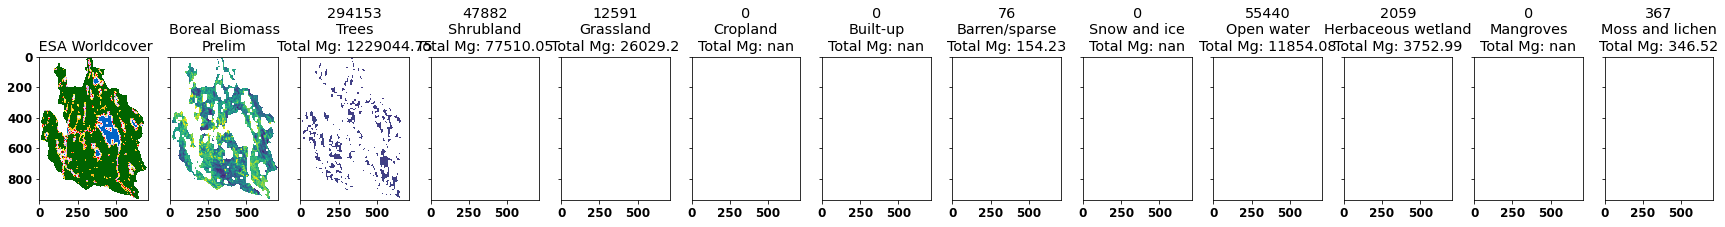

In [31]:
## %%time

# The area in hectares of a 30m pixel
area_pix_ha = 0.09

# The land cover values in which you want to summarize AGB
values_worldcover = [10,20,30,40,\
                     50,\
                     60,70,80,90,95,100] #'Trees', 'Shrubland', 'Grassland','Cropland', 'Barren / sparse vegetation', 'Herbaceous wetland','Moss and lichen'

fig, axes = plt.subplots(nrows=1, ncols=len(values_worldcover)+2, figsize=(30,10), sharex=True, sharey=True)

# Read back in the topo_stack_cog_fn and plot

with rasterio.open(BASIN_COG_DICT['landcover_cog_fn']) as dataset:
    
    lc_meta = dataset.profile
    
    print(f"\nArea (ha.) of extent {TILE_NUM}:\t\t{basin_area_ha}")
    
    lc_arr = dataset.read(1)
    print(f"\nlc_arr shape: {lc_arr.shape}")
    
    # NoData value is 0; mask this
    lc_arr = np.ma.masked_where( lc_arr == 0, lc_arr)
    
    # Plotting
    names_worldcover = [ 'Trees', 'Shrubland', 'Grassland','Cropland',\
                        'Built-up',
                        'Barren/sparse','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = [ "#006400","#ffbb22","#ffff4c","#f096ff",\
                       "#fa0000",\
                       "#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    #cols_mask = ["white", "red"]
    #values_mask = [0,1]

    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))

    #cmap_masked = ListedColormap(cols_mask)
    #norm_masked= BoundaryNorm(values_mask, len(cols_mask))
    
    axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
    axes[0].set_title(f" ESA Worldcover")
    
    # Find sum of AGB per LC class
    # multiply by AGB values and sum
    with rasterio.open(BASIN_COG_DICT['biomass_cog_fn']) as dataset_agb:
        
        print(dataset_agb.profile)
        
        agb_arr = dataset_agb.read(1)
        print(f"agb nodata value: {dataset_agb.nodata}")
        
        #agb_arr = np.ma.masked_where( (lc_arr==0) | (agb_arr<0), agb_arr)
        agb_arr = np.ma.masked_where(  (agb_arr<0), agb_arr)
        total_mg_all = np.nansum(agb_arr)
        
        print(f"agb_arr shape: {agb_arr.shape}\n")
        axes[1].imshow(agb_arr, clim=(0,75))
        axes[1].set_title(f"Boreal Biomass\nPrelim")
    
        for i, LC_VALUE in enumerate(values_worldcover):
        #for i, LC_VALUE in enumerate([v for v in LC_VAL_LIST if v in values_worldcover ]):

            LC_NAME = names_worldcover[i]
            print(i, LC_NAME, LC_VALUE)

            # For LC value of interest
            #lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr != LC_VALUE) , agb_arr)
            lc_agb_arr = np.ma.masked_where( (lc_arr != LC_VALUE) , agb_arr)
            
            num_lc_pixels_in_mask = lc_agb_arr[~np.isnan(lc_agb_arr)].count() 
            num_lc_pixels_in_mask = lc_agb_arr.count()
            total_lc_area_ha = num_lc_pixels_in_mask * area_pix_ha
            
            print(f"\t# land cov pixels in class:\t\t\t{num_lc_pixels_in_mask}")
            print(f"\t# Total area (ha.) in class:\t\t\t{total_lc_area_ha} ({round(100 * total_lc_area_ha / basin_area_ha,2)}% of extent)")
            
            total_mg_lc = np.nan
            
            if False and LC_VALUE == 40:
                list_of_vals = lc_agb_arr[lc_agb_arr.mask == False].tolist()
                print(list_of_vals)
                #print(f"\t\t{(sum(list_of_vals) / num_lc_pixels_in_mask) * area_pix_ha}")
                
            if LC_VALUE == 10:
                trees_lc_agb_arr = lc_agb_arr
            
            if num_lc_pixels_in_mask > 0:
                
                print(f"\tMg/ha (min,mean,med,max):\t\t\t\t{round(np.nanmin(lc_agb_arr),2)}, {round(np.nanmean(lc_agb_arr),2)}, {round(np.ma.median(lc_agb_arr),2)} , {round(np.nanmax(lc_agb_arr),2)}")

                # ***To get error bars on total (Mg), need to have mean AGB raster and sd AGB raster, and use them to sample a normal distribution of AGB values per pixel, n=100 times per pixel?
                # Then get all the totals from the n layers, and get the mean total and the sd of the total
                #total_mg_lc = (lc_agb_arr.sum() / num_lc_pixels_in_mask) * area_pix_ha
                total_mg_lc = np.nansum(lc_agb_arr * area_pix_ha)
                print(f"\tTotal AGB (Mg) in class:\t\t\t{round( total_mg_lc, 2)} ({round(100 * total_mg_lc / total_mg_all,2)}% of extent biomass)")
            
            # To plot with a legend: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
            axes[i+2].imshow(lc_agb_arr, clim=(-100,700))
            axes[i+2].set_title(f"{num_lc_pixels_in_mask}\n{LC_NAME}\nTotal Mg: {round(total_mg_lc,2)}")
            
            #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
            #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [32]:
!pip install -U matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar
def add_colorbar(mappable, label):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(label)
    plt.sca(last_axes)
    return cbar



  Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl (17 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Map biomass for Tree extents
The extent of 'trees' in the ESA Worldcover v1 2020 land cover dataset provides an independent mask to sum biomass for each polygon

Extent:		2139
Total ha.:		31830.39
Mean Mg/ha:		42.0
Total Pg.:		0.0013
Mean Mg/ha in trees:	46.84
Total Pg. in trees:	0.0012


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


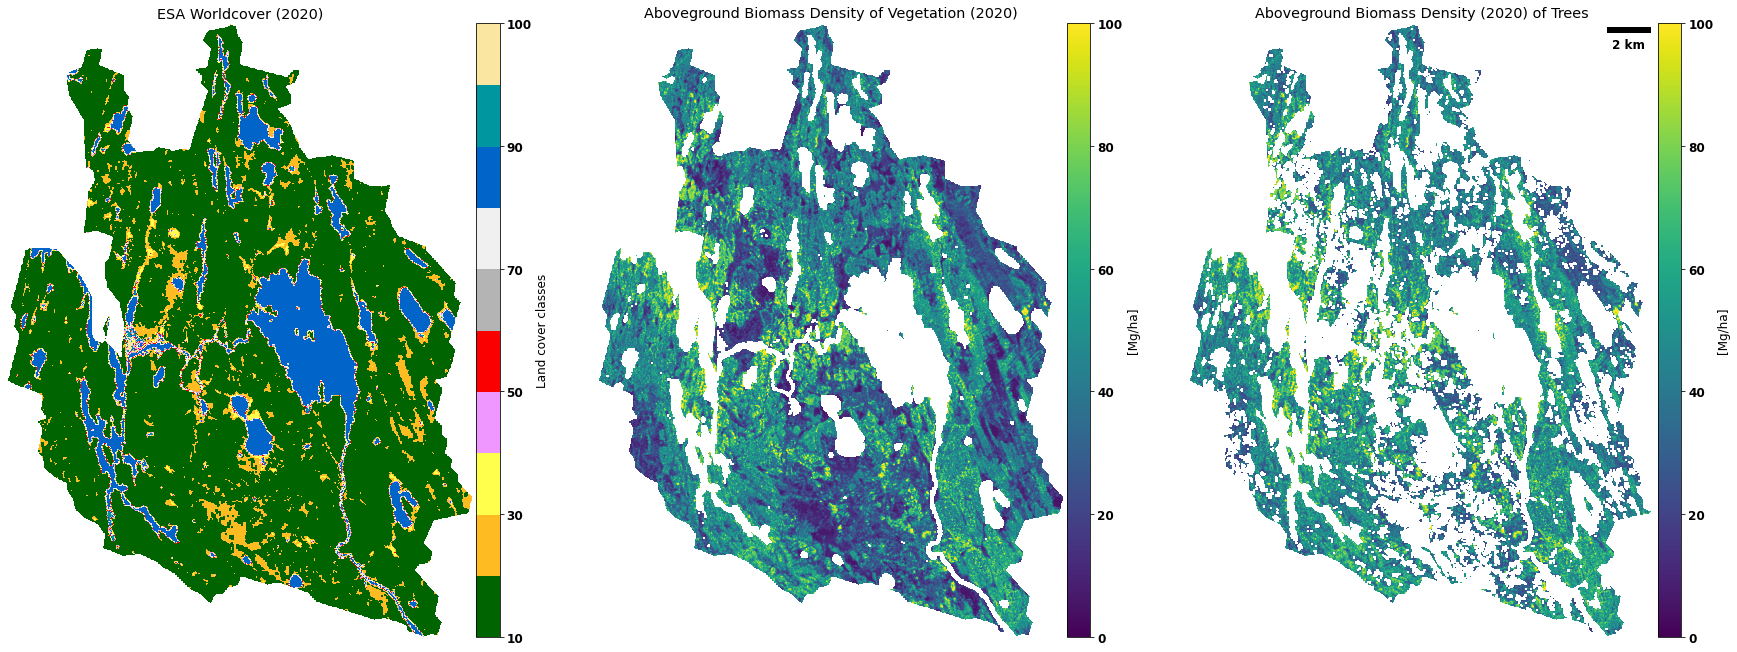

In [33]:
LC_VAL = 10
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

##########
# AGB arrays
# With a water mask
agb_arr_masked = np.ma.masked_where( (lc_arr == 0  ) | (lc_arr == 80) , agb_arr)

##########
# Without a water mask
#agb_arr_masked = np.ma.masked_where( (lc_arr == 0  )  ,agb_arr)

##########
# AGB density of ESA Worldcover v1 2020 trees 
agb_arr_masked_trees = np.ma.masked_where( (lc_arr != LC_VAL  ), agb_arr_masked)

print(f"Extent:\t\t{TILE_NUM}")
print(f"Total ha.:\t\t{(agb_arr_masked[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }")
print(f"Mean Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }")
print(f"Mean Mg/ha in trees:\t{ round(np.nanmean(agb_arr_masked_trees),2) }")
print(f"Total Pg. in trees:\t{round(np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha, 4) }")

# Plots

# Showing only trees LC
#m2 = axes[1].imshow(lc_arr_trees, cmap=cmap_worldcover, norm=norm_worldcover)
# Showing all LC classes
m1 = axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m1, 'Land cover classes')
axes[0].set_title('ESA Worldcover (2020)')
axes[0].axis('off')

m2 = axes[1].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m2, '[Mg/ha]')
m2 = axes[1].set_title('Aboveground Biomass Density of Vegetation (2020)')
axes[1].axis('off')

# Show AGB for tree
m3 = axes[2].imshow(agb_arr_masked_trees, clim=(0,100), cmap='viridis')
add_colorbar(m3, '[Mg/ha]')
m3 = axes[2].set_title('Aboveground Biomass Density (2020) of Trees')
axes[2].axis('off')

if False:
    # Convert AGB density to total
    m4 = axes[3].imshow(agb_arr_masked_trees* area_pix_ha, clim=(0,10), cmap='plasma')
    add_colorbar(m3, '[Mg]')
    m4 = axes[3].set_title('Aboveground Biomass (2020) of Trees')
    axes[3].axis('off')

# Carbon accumulation

In [53]:
ndv_standage = 255
ndv_tccslope = 255
ndv_tcc = 255
standage_arr = rasterio.open(BASIN_COG_DICT['standage_cog_fn']).read(1)
tccslope_arr = rasterio.open(BASIN_COG_DICT['tccslope_cog_fn']).read(1)
tcc2020_arr = rasterio.open(BASIN_COG_DICT['tcc2020_cog_fn']).read(1)

Extent:		2139

Total ha.:		26239.32

Mean AGB Mg/ha in all classes (even water):		41.98
Total AGB Pg. in all classes (even water):	0.0013
Water AGB adds additional 1.2e-05 Pg. to the Total land AGB, an increase of 0.887 %

Mean AGB Mg/ha:		42.0
Total AGB Pg.:		0.0013

Mean AGB Mg/ha in trees:	46.84
Total AGB Pg. in trees:	0.0012
Tree AGB is 0.9194 of Total land AGB

Mean Net C accumulation in trees:	0.49 MgC/ha/yr
Total Pg. C in trees:	0.0 Pg
Mean Net C accumulation in all classes:	0.45 MgC/ha/yr
Total Pg. C in all classes:	0.0 Pg
Tree C is 0.9033 of Total land aboveground C

This C proportion doesnt match the AGB proportion due to pixel with stand age = 0
---This doesnt make sense yet --> Adjusted Tree C is 0.784 of Total land aboveground C



(-0.5, 710.5, 936.5, -0.5)

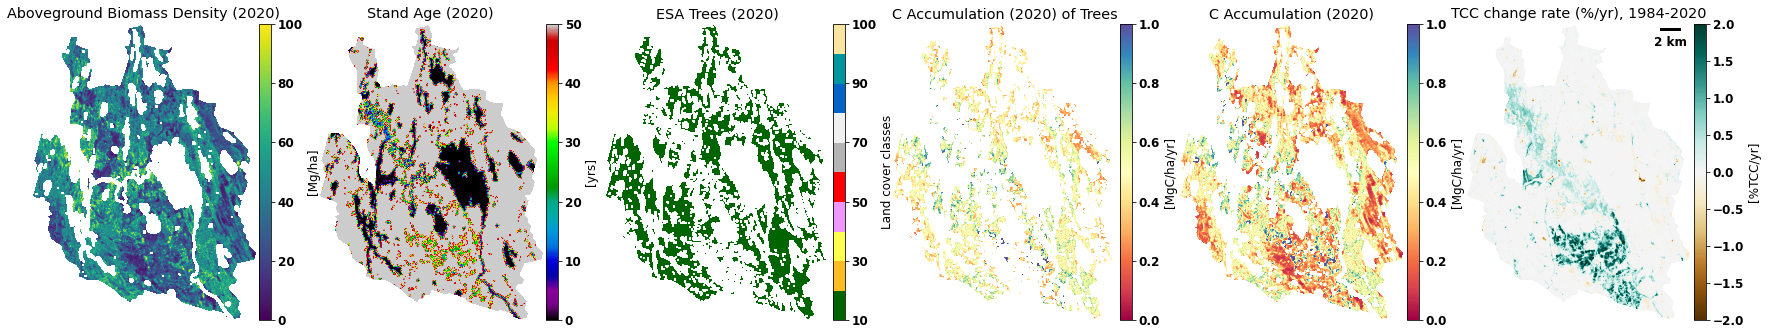

In [54]:
val_lc_nodata, val_lc_trees, val_lc_water = [0, 10, 80]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

#
# Stand age masked with its nodata
#
standage_arr_masked = np.ma.masked_where( (standage_arr == ndv_standage ), standage_arr) # <-- note, leaving in age = 0 here, technically not 'stands'? or just 'recently disturbed stands' - how to get C accumulation when denom is 0?
standage_arr_masked_adj = np.ma.where(standage_arr_masked == 0, 0.5, standage_arr_masked) # <-- instead of age = 0, age = 0.5
standage_arr_masked_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), standage_arr_masked)
standage_arr_masked_adj_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), standage_arr_masked_adj)

#
# LC masked with its nodata and water
#
lc_arr_masked = np.ma.masked_where( (lc_arr == val_lc_nodata  ) | (lc_arr == val_lc_water) , lc_arr)
lc_arr_trees = np.ma.masked_where( (lc_arr != val_lc_trees  )  , lc_arr_masked)

# TCC variables masked with its nodata
tccslope_arr = np.ma.masked_where( (tccslope_arr == ndv_tccslope ) , tccslope_arr)
tcc2020_arr = np.ma.masked_where( (tcc2020_arr == ndv_tcc ) , tcc2020_arr)

# AGB masked with lc nodata
agb_water_arr_masked = np.ma.masked_where( (lc_arr == val_lc_nodata  )  , agb_arr)
# ..and additionally with water
agb_arr_masked = np.ma.masked_where(  (lc_arr == val_lc_water) , agb_water_arr_masked)
# ..and additionally with ESA Worldover trees
agb_arr_masked_trees = np.ma.masked_where( (lc_arr != val_lc_trees  ), agb_arr_masked)

# Carbon accumulation per year (Annual net C accumulation rate)
ratio_c_agb = 0.5
netc_accum_arr = (agb_arr_masked * ratio_c_agb) / standage_arr_masked
netc_accum_arr_adj= (agb_arr_masked * ratio_c_agb) / standage_arr_masked_adj
netc_accum_arr_trees = (agb_arr_masked_trees * ratio_c_agb) / standage_arr_masked
netc_accum_arr_trees_adj = (agb_arr_masked_trees * ratio_c_agb) / standage_arr_masked_adj


# Get the total water AGB
land_water_agb_total = (np.nansum(agb_water_arr_masked)/1e9 * area_pix_ha)
land_agb_total = (np.nansum(agb_arr_masked)/1e9 * area_pix_ha)
water_agb_total = land_water_agb_total - land_agb_total

print(f"Extent:\t\t{TILE_NUM}\n")
print(f"Total ha.:\t\t{(agb_arr_masked_trees[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }\n")

print(f"Mean AGB Mg/ha in all classes (even water):\t\t{ round(np.nanmean(agb_arr),2) }")
print(f"Total AGB Pg. in all classes (even water):\t{round(np.nansum(agb_arr)/1e9 * area_pix_ha, 4) }")
print(f"Water AGB adds additional { round(water_agb_total, 6)} Pg. to the Total land AGB, an increase of { round(water_agb_total / land_agb_total * 100 , 3) } %\n")

# Land AGB
print(f"Mean AGB Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total AGB Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }\n")

# Tree AGB
print(f"Mean AGB Mg/ha in trees:\t{ round(np.nanmean(agb_arr_masked_trees),2) }")
print(f"Total AGB Pg. in trees:\t{round(np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha, 4) }")
print(f"Tree AGB is {round(  (np.nansum(agb_arr_masked_trees)/1e9 * area_pix_ha) / (np.nansum(agb_arr_masked)/1e9 * area_pix_ha)  , 4) } of Total land AGB\n")

# Carbon accumulation
print(f"Mean Net C accumulation in trees:\t{ round(np.nanmean( netc_accum_arr_trees),2) } MgC/ha/yr")
print(f"Total Pg. C in trees:\t{round(np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha, 4) } Pg")
print(f"Mean Net C accumulation in all classes:\t{ round(np.nanmean( netc_accum_arr),2) } MgC/ha/yr")
print(f"Total Pg. C in all classes:\t{round(np.nansum(netc_accum_arr)/1e9 * area_pix_ha, 4) } Pg")
print(f"Tree C is {round(  (np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha) / (np.nansum(netc_accum_arr)/1e9 * area_pix_ha)  , 4) } of Total land aboveground C\n")
print("This C proportion doesnt match the AGB proportion due to pixel with stand age = 0")
print(f"---This doesnt make sense yet --> Adjusted Tree C is {round(  (np.nansum(netc_accum_arr_trees_adj)/1e9 * area_pix_ha) / (np.nansum(netc_accum_arr_adj)/1e9 * area_pix_ha)  , 4) } of Total land aboveground C\n")

# Plots
# Biomass
m1 = axes[0].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m1, '[Mg/ha]')
m1 = axes[0].set_title('Aboveground Biomass Density (2020)')
axes[0].axis('off')

# Age
m2 = axes[1].imshow(standage_arr_masked, cmap='nipy_spectral')
add_colorbar(m2, '[yrs]')
axes[1].set_title('Stand Age (2020)')
axes[1].axis('off')

# Showing trees instead of all LC classes
m3 = axes[2].imshow(lc_arr_trees, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m3, 'Land cover classes')
axes[2].set_title('ESA Trees (2020)')
axes[2].axis('off')

# Carbon accumulation in trees
m4 = axes[3].imshow(netc_accum_arr_trees, clim=(0,1), cmap='Spectral')
add_colorbar(m4, '[MgC/ha/yr]')
m4 = axes[3].set_title('C Accumulation (2020) of Trees')
axes[3].axis('off')

# Carbon accumulation in all classes
m5 = axes[4].imshow(netc_accum_arr, clim=(0,1), cmap='Spectral')
add_colorbar(m5, '[MgC/ha/yr]')
m5 = axes[4].set_title('C Accumulation (2020)')
axes[4].axis('off')

# TCC trend 1984-2020
m6 = axes[5].imshow(tccslope_arr, clim=(-2,2), cmap='BrBG')
add_colorbar(m6, '[%TCC/yr]')
m6 = axes[5].set_title('TCC change rate (%/yr), 1984-2020')
axes[5].axis('off')

#### Check trees and C accum with larger maps

(-0.5, 710.5, 936.5, -0.5)

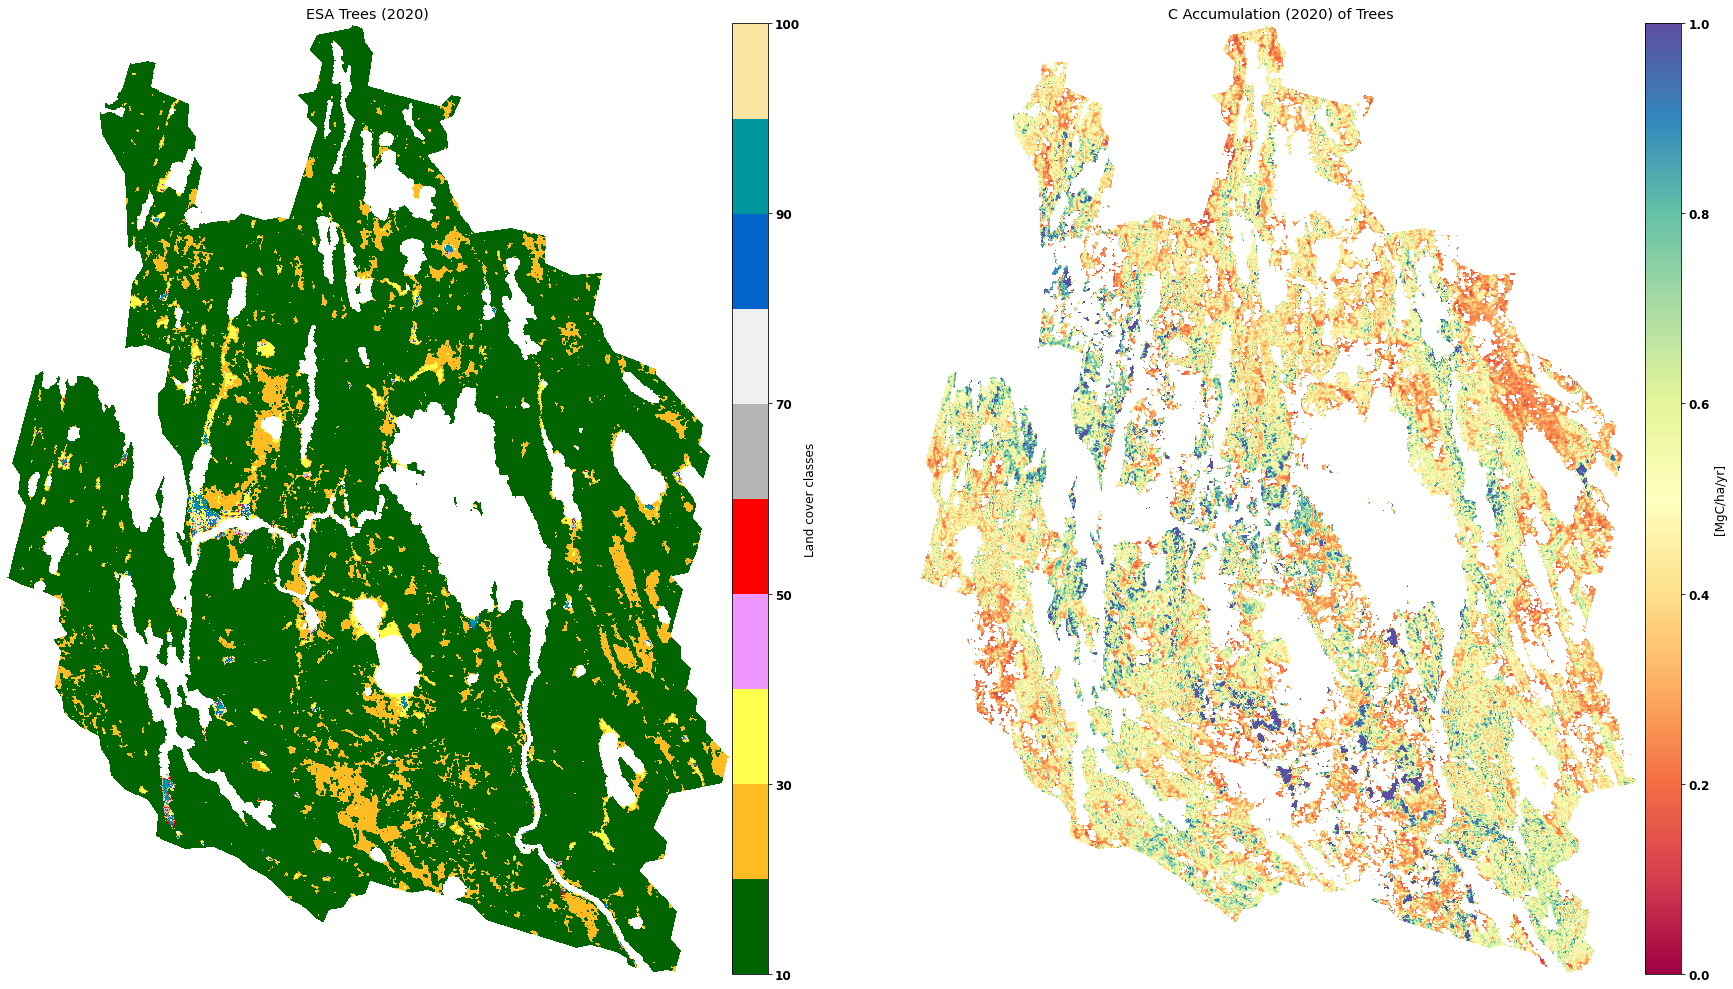

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,30), sharex=True, sharey=True)
# Showing trees instead of all LC classes
m3 = axes[0].imshow(lc_arr_masked, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m3, 'Land cover classes')
axes[0].set_title('ESA Trees (2020)')
axes[0].axis('off')

# Carbon accumulation in trees
m4 = axes[1].imshow(netc_accum_arr_trees, clim=(0,1), cmap='Spectral')
add_colorbar(m4, '[MgC/ha/yr]')
m4 = axes[1].set_title('C Accumulation (2020) of Trees')
axes[1].axis('off')

#### Check stand age in trees vs all stand age

### Stand age, carbon accumulation, and tree cover rate change maps

(-0.5, 710.5, 936.5, -0.5)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


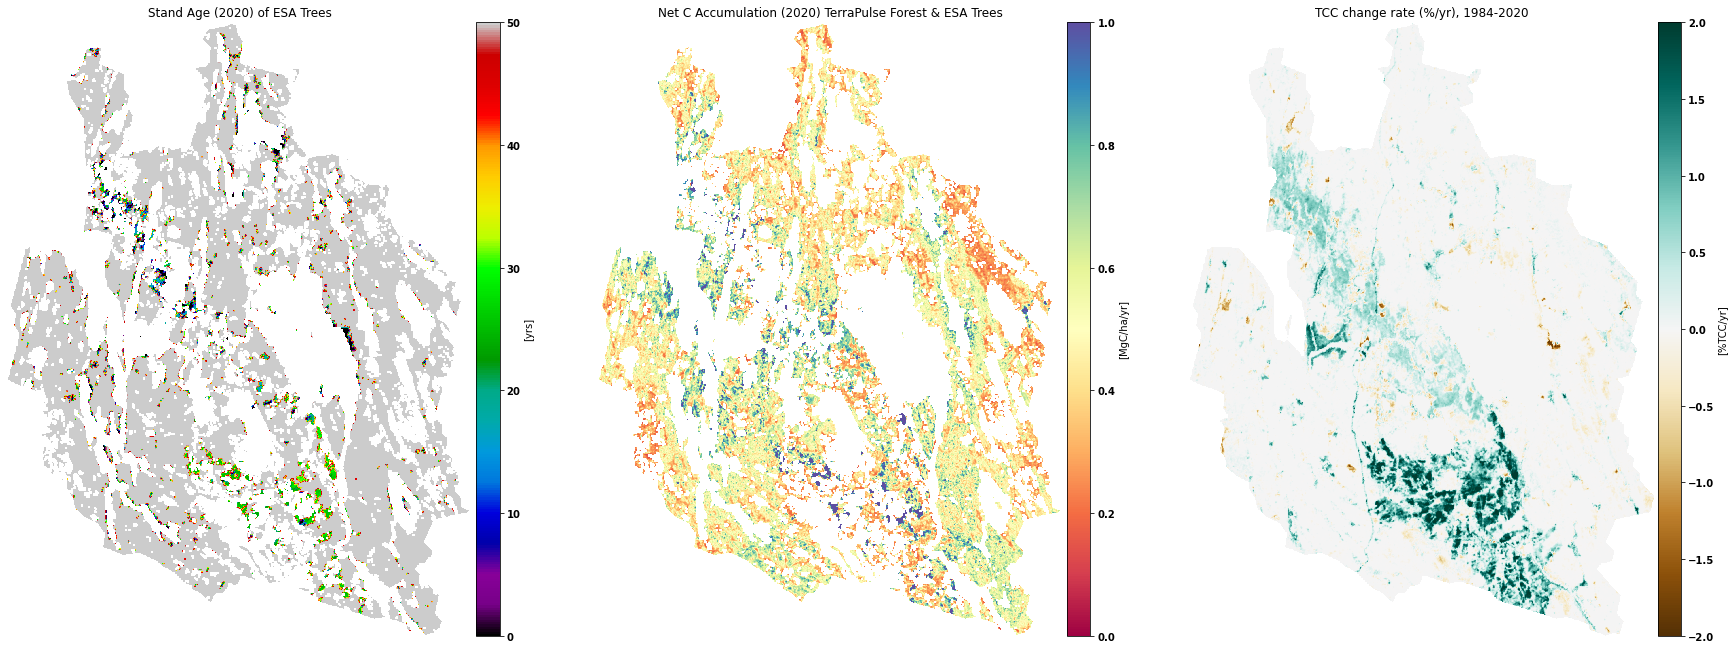

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Age
m2 = axes[0].imshow(standage_arr_masked_trees, cmap='nipy_spectral')
add_colorbar(m2, '[yrs]')
axes[0].set_title('Stand Age (2020) of ESA Trees')
axes[0].axis('off')

# Carbon accumulation
m5 = axes[1].imshow(netc_accum_arr_trees, clim=(0,1), cmap='Spectral')
add_colorbar(m5, '[MgC/ha/yr]')
m5 = axes[1].set_title('Net C Accumulation (2020) TerraPulse Forest & ESA Trees')
axes[1].axis('off')

# TCC trend 1984-2020
m6 = axes[2].imshow(tccslope_arr, clim=(-2,2), cmap='BrBG')
add_colorbar(m6, '[%TCC/yr]')
m6 = axes[2].set_title('TCC change rate (%/yr), 1984-2020')
axes[2].axis('off')

### Binned scatterplots

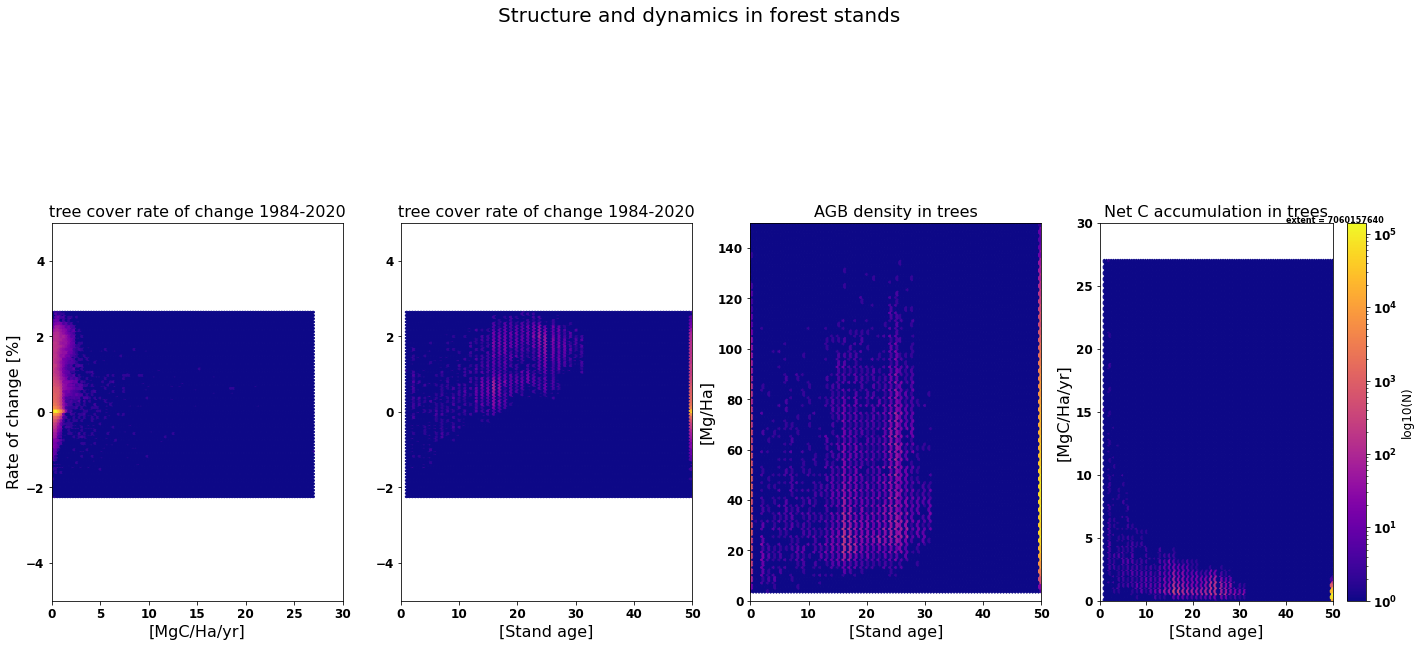

In [52]:
# Mask TCC trends with 
tccslope_masked = np.ma.masked_where(netc_accum_arr_trees.mask, tccslope_arr)

lims_c_accum = [0,30]
lims_stand_age = [0,50]
lims_tcc_change = [-5, 5]

#Declaring the figure, and hiding the ticks' labels
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,10))
st = fig.suptitle("Structure and dynamics in forest stands", fontsize=20,  horizontalalignment='center')

## Actually Plotting the data
# Binned scatterplots
ax1.hexbin(np.ravel(netc_accum_arr_trees), np.ravel(tccslope_masked), gridsize=100, bins='log', cmap='plasma')
ax2.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(tccslope_masked), gridsize=100, bins='log', cmap='plasma')
ax3.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(agb_arr_masked_trees), gridsize=100, bins='log', cmap='plasma')
hb=ax4.hexbin(np.ravel(standage_arr_masked_trees), np.ravel(netc_accum_arr_trees), gridsize=100, bins='log', cmap='plasma')


# Scatterplots
#ax1.scatter(np.ravel(netc_accum_arr_trees), np.ravel(tccslope_masked),  s=0.1, c='black', alpha=0.01)
#ax2.scatter(np.ravel(standage_arr_masked_trees), np.ravel(tccslope_masked),  s=0.1, c='black', alpha=0.01)
#ax3.scatter(np.ravel(standage_arr_masked_trees), np.ravel(netc_accum_arr_trees),  s=0.1, c='black', alpha=0.01)

#Making the graph pretty and informative!
ax1.set_title("tree cover rate of change 1984-2020", fontsize=16)
ax1.set_ylabel("Rate of change [%]", fontsize=16)
ax1.set_xlabel("[MgC/Ha/yr]", fontsize=16)
ax1.set_ylim(lims_tcc_change)

ax2.set_title("tree cover rate of change 1984-2020", fontsize=16)
ax2.set_xlabel("[Stand age]", fontsize=16)
ax2.set_ylim(lims_tcc_change)

ax3.set_title("AGB density in trees", fontsize=16)
ax3.set_ylabel("[Mg/Ha]", fontsize=16)
ax3.set_ylim((0,150))
ax3.set_xlabel("[Stand age]", fontsize=16)

ax4.set_title("Net C accumulation in trees", fontsize=16)
ax4.set_ylabel("[MgC/Ha/yr]", fontsize=16)
ax4.set_ylim(lims_c_accum)
ax4.set_xlabel("[Stand age]", fontsize=16)
ax4.text(0.80,
         1.0, 
         f"extent = {extent_id}",
         transform=plt.gca().transAxes,
         color = "black",
         fontsize=8
        )
cb = fig.colorbar(hb, ax=ax4)
cb.set_label('log10(N)')

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.65)

ax1.set_xlim(lims_c_accum)
ax2.set_xlim(lims_stand_age)
ax3.set_xlim(lims_stand_age)
ax4.set_xlim(lims_stand_age)
plt.show()

# Try this next but need to remove nans from each array: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

## Questions to answer
For trees in stands =< 36 yrs, 
1. what is the total AGB (Pg) and what is C?  
2. what is the percentage of overall C?

## Write a new stack
Band 1: ESA WorldCover  
Band 2: ABoVE AGB for ESA veg mask  
Band 3: ABoVE AGB for ESA tree mask  
Band 4: ABoVE Net C accumulation in trees with stand age (TP forest stand age x ESA tree mask ) 
 - not doing this stack correctly - fill value and nodata need to be looked at


In [56]:
# Stack
# move axis of the stack so bands is first
# LC array (int) mask filled with 0 .... AGB arrays (floats) filled with nan
#analysis_stack = np.stack([lc_arr.filled(0) , agb_arr_masked.filled(-9999) , agb_arr_masked_trees.filled(-9999) ])
analysis_stack = np.stack([lc_arr, agb_arr_masked , agb_arr_masked_trees,  standage_arr_masked_trees])
analysis_stack_names = ["lc", "agb_veg", "agb_tree", "stand_age" ]

# Copy input agb metadata
out_meta = dataset_agb.profile
out_meta

# write COG to disk
write_cog(
            analysis_stack, 
            os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif", 
            out_meta['crs'], 
            out_meta['transform'], 
            analysis_stack_names, 
            out_crs=out_meta['crs'],
    input_nodata_value= -9999
             )

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/52c6ad3c-bc37-4cb3-af62-e202ded84582/52c6ad3c-bc37-4cb3-af62-e202ded84582.tif)' mode='r'>


Orig stack shape:		 (4, 937, 711)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float64', 'nodata': -9999, 'width': 711, 'height': 937, 'count': 4, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 4067117.7888277615,
       0.0, -30.0, 4586811.806507512), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog_ESA_trees.tif


Image written to disk:		 /projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_final_7060157640_cog_ESA_trees.tif


True

None


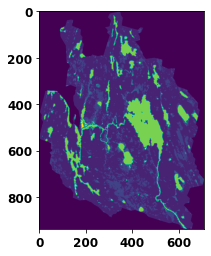

In [63]:
src = rasterio.open(os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif")
print(src.profile['nodata'])
arr = src.read(1)
#arr = np.ma.masked_where((arr <0) , arr)
show(arr)

## Read rasters from stack

In [64]:
def examine_raster(r_fn, ndv, band=1):
    with rasterio.open(r_fn) as ds:
        
        print(ds.nodata)

        arr = ds.read(band)

        arr = np.ma.masked_where(arr == ndv, arr)
        show_hist(arr)

In [42]:
#examine_raster(os.path.splitext(BASIN_COG_DICT['biomass_cog_fn'])[0] + "_ESA_trees.tif", -9999., band=2)

None


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


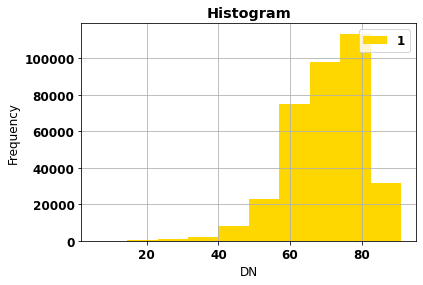

In [65]:
examine_raster(BASIN_COG_DICT['tcc2020_cog_fn'], ndv_tcc)

None


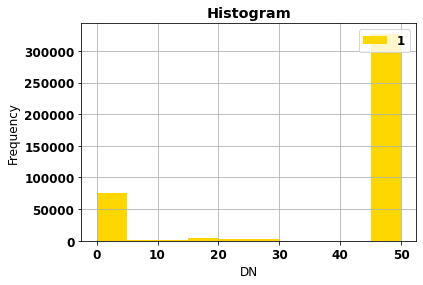

In [66]:
examine_raster(BASIN_COG_DICT['standage_cog_fn'], ndv_standage)

None


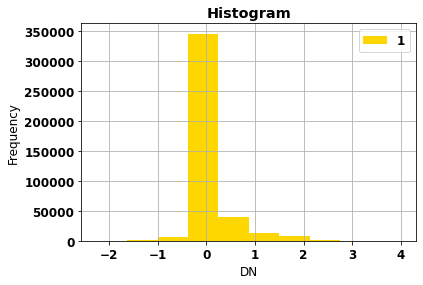

In [67]:
examine_raster(BASIN_COG_DICT['tccslope_cog_fn'], ndv_tccslope)

# Stack the masked data and build a dataframe
https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe

In [68]:
%matplotlib inline

#Return a common mask for a set of input ma
def common_mask(ma_list, apply=False):
    if type(ma_list) is not list:
        print("Input must be list of masked arrays")
        return None
    #Note: a.mask will return single False if all elements are False
    #np.ma.getmaskarray(a) will return full array of False
    #ma_list = [np.ma.array(a, mask=np.ma.getmaskarray(a), shrink=False) for a in ma_list]
    a = np.ma.array(ma_list, shrink=False)
    #Check array dimensions
    #Check dtype = bool
    #Masked values are listed as true, so want to return any()
    #a+b+c - OR (any)
    mask = np.ma.getmaskarray(a).any(axis=0)
    #a*b*c - AND (all)
    #return a.all(axis=0)
    if apply:
        return [np.ma.array(b, mask=mask) for b in ma_list] 
    else:
        return mask

#
# --UPDATE TO A COMMON MASK for the stack
#
arr_list = common_mask([lc_arr_masked, agb_arr_masked, standage_arr_masked, netc_accum_arr, tccslope_arr, tcc2020_arr], apply=True)
#arr_list = [lc_arr_masked, agb_arr_masked, standage_arr_masked, netc_accum_arr, tccslope_arr, tcc2020_arr]

print(arr_list[0].count())
stack = np.stack([arr[(netc_accum_arr>=0) & (tcc2020_arr < 255)].data.flatten() for arr in arr_list],axis=1)

# Common mask
#stack = common_mask(stack, apply=True)

# Build data frame
VARS_LIST = ['LC','Mg_ha', 'Age_yr','Mg_C_ha_yr','TCC_slope','TCC_2020']
stack_df = pd.DataFrame(stack, columns = VARS_LIST)

# Clean
stack_df['Age_yr'] = stack_df['Age_yr'].apply(int)
remap_dict = dict(zip(values_worldcover, names_worldcover))
stack_df['LC'] = stack_df['LC'].replace(remap_dict)
stack_df['LC'] = pd.Categorical(stack_df['LC'], categories=names_worldcover, ordered=True)
stack_df.info()

333604
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348000 entries, 0 to 347999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   LC          348000 non-null  category
 1   Mg_ha       348000 non-null  float64 
 2   Age_yr      348000 non-null  int64   
 3   Mg_C_ha_yr  348000 non-null  float64 
 4   TCC_slope   348000 non-null  float64 
 5   TCC_2020    348000 non-null  float64 
dtypes: category(1), float64(4), int64(1)
memory usage: 13.6 MB


### Histogram of TCC rate of change, 1984-2020

In [69]:
stack_df.head()
# -- get a summary here to check that invalid values are removed

LC      Mg_ha  Age_yr  Mg_C_ha_yr  TCC_slope  TCC_2020
0       Trees  66.979851      50    0.669799   0.000000      83.0
1  Open water  39.712601       0   39.712601   0.613729      81.0
2       Trees  63.197826      50    0.631978   0.000000      84.0
3       Trees  41.164677      50    0.411647   0.039829      73.0
4       Trees  33.391151      50    0.333912   0.348269      69.0

This will kill the kernel

In [70]:
if False:
    plotnine.options.figure_size = (5, 2)

    # Melt
    stack_df['pix_idx'] = stack_df.index

    stack_df_m = pd.melt(stack_df, id_vars=['pix_idx'], value_vars=VARS_LIST)

    median_tcc_val = stack_df.TCC_slope.median()                  
    print(f"Median TCC change rate, 1984-2020 (% TCC/yr):\t\t{median_tcc_val}")
    print(
        (
            ggplot(aes( x='value', fill='variable'), data=stack_df_m ) 
            + geom_histogram(binwidth=1)
            + geom_vline(xintercept=0, linetype = 'dashed')
            #+ scale_fill_brewer(palette='BrBG', type="diverging")
            #+ coord_cartesian(xlim=(-4,4))
            + facet_grid('variable~.')
            + theme_minimal()
        ) 
    )

# Summarize by land cover
summarize 
+ biomass density
+ carbon accumulation rate

by
+ land cover
+ age

In [71]:
stack_df_smry = pd.DataFrame(
    stack_df.groupby(["LC","Age_yr"]).agg(
            {
            "Mg_ha": ["sum", "min", "max", "median", "skew", "std", "count"], # np.nansum(netc_accum_arr_trees)/1e9 * area_pix_ha
            "Mg_C_ha_yr": ["min", "max", "median", "skew", "std", "count"]#,
            #"Age_yr": ["min", "max", "median", "skew", "std", "count"]
              }
                        )
    
)
##stack_df_smry['LC'] = stack_df_smry.index
stack_df_smry.index = stack_df_smry.index.set_names(['LC', 'Age'])

stack_df_smry.reset_index(drop=False, inplace=True)

stack_df_smry.columns = [' '.join(col).strip() for col in stack_df_smry.columns.values]

# Convert sum to Pg, normalize sum by area of pixel
stack_df_smry['Total_Pg'] = stack_df_smry['Mg_ha sum']/1e9 * area_pix_ha

stack_df_smry.dropna()


LC  Age      Mg_ha sum  Mg_ha min   Mg_ha max  \
0                 Trees    0  242429.291412   4.035906  125.763229   
2                 Trees    2    2938.028065   6.220661  107.797241   
3                 Trees    3     745.311738   4.364656   81.760376   
4                 Trees    4     907.894817   5.479277   99.600647   
5                 Trees    5    1739.196548  11.247076   98.699181   
..                  ...  ...            ...        ...         ...   
283  Herbaceous wetland   19     132.991732  18.394213   36.653606   
287  Herbaceous wetland   23      78.480505  12.543639   33.813251   
296  Herbaceous wetland   50    6542.324432   5.644676   67.885498   
330     Moss and lichen    0    1637.614512   6.513044   98.046638   
362     Moss and lichen   50    1022.711490   8.884817   61.691757   

     Mg_ha median  Mg_ha skew  Mg_ha std  Mg_ha count  Mg_C_ha_yr min  \
0       35.635372    0.779311  23.150467         5838        2.017953   
2       22.188044    1.955871  18.741506          107        1.555165   
3       20.992149    1.129470  20.897130           26        0.727443   
4       28.078166    1.387293  22.287964           30        0.684910   
5       34.057156    1.303577  22.332297           44        1.124708   
..            ...         ...        ...          ...             ...   
283     24.304440    0.485736   7.465606            5        0.484058   
287     16.061807    1.780171   9.641305            4        0.272688   
296     23.523033    0.660792  12.437213          257        0.056447   
330     20.395066    2.157413  15.149610           70        3.256522   
362     31.748397    0.512288  15.052793           32        0.088848   

     Mg_C_ha_yr max  Mg_C_ha_yr median  Mg_C_ha_yr skew  Mg_C_ha_yr std  \
0         62.881615          17.817686         0.779311       11.575234   
2         26.949310           5.547011         1.955871        4.685377   
3         13.626729           3.498692         1.129470        3.482855   
4         12.450081           3.509771         1.387293        2.785995   
5          9.869918           3.405716         1.303577        2.233230   
..              ...                ...              ...             ...   
283        0.964569           0.639591         0.485736        0.196463   
287        0.735071           0.349170         1.780171        0.209594   
296        0.678855           0.235230         0.660792        0.124372   
330       49.023319          10.197533         2.157413        7.574805   
362        0.616918           0.317484         0.512288        0.150528   

     Mg_C_ha_yr count      Total_Pg  
0                5838  2.181864e-05  
2                 107  2.644225e-07  
3                  26  6.707806e-08  
4                  30  8.171053e-08  
5                  44  1.565277e-07  
..                ...           ...  
283                 5  1.196926e-08  
287                 4  7.063245e-09  
296               257  5.888092e-07  
330                70  1.473853e-07  
362                32  9.204403e-08  

[111 rows x 16 columns]

In [73]:
FILTER_LIST = ['Open water', 'Barren/sparse', 'Built-up']
KEEP_LIST = ['Trees']

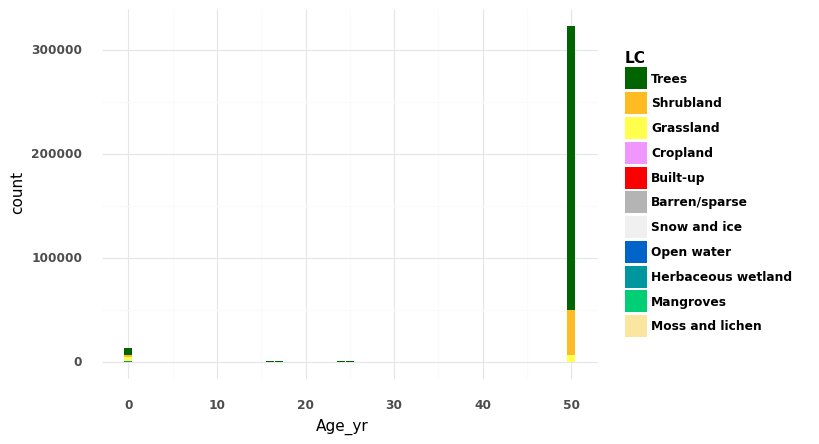

<ggplot: (8775696411889)>

In [74]:
(
    ggplot(aes( x='Age_yr', fill='LC'), data=stack_df.dropna()[~stack_df['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='count')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + theme_minimal()
) 

### Total Biomass per land cover class

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


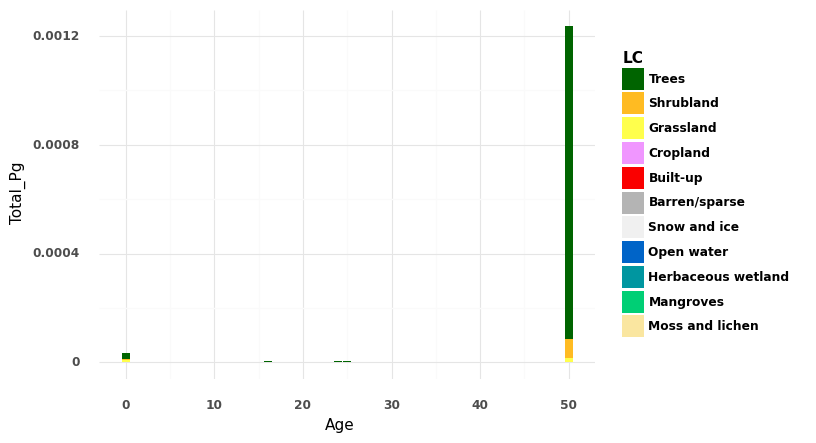

<ggplot: (8775696107125)>

In [75]:

(
    ggplot(aes(y='Total_Pg', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + theme_minimal()
) 

### Carbon accumulation rate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


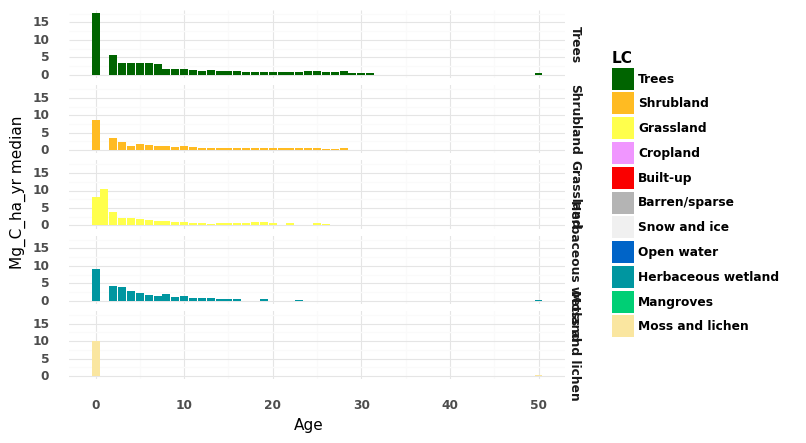

<ggplot: (8775695067325)>

In [77]:
(
    ggplot(aes(y='Mg_C_ha_yr median', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + facet_grid('LC~.')
    + theme_minimal()
) 

## TCC change rate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


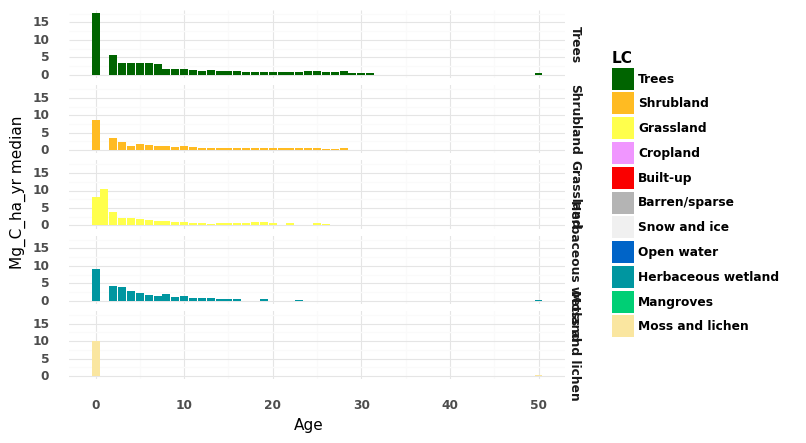

<ggplot: (8775396018717)>

In [76]:
(
    ggplot(aes(y='Mg_C_ha_yr median', x='Age', fill='LC'), data=stack_df_smry.dropna()[~stack_df_smry['LC'].isin(FILTER_LIST)] ) 
    + geom_bar(stat='identity')
    + scale_fill_manual(values=dict(zip(names_worldcover, cols_worldcover)))
    + facet_grid('LC~.')
    + theme_minimal()
)

In [ ]:
p = ggplot(aes(x='Mg_C_ha_yr', fill='LC'), data=df)
p + geom_histogram(binwidth=1)